In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display
import os, os.path
import math
import skimage
import cv2

In [3]:
PATH_TO_BIRDCLEF = "../birdclef-2022"
PATH_TO_SPECTRO = f"{PATH_TO_BIRDCLEF}/train_spectro"

In [4]:
meta = pd.read_csv(f"{PATH_TO_BIRDCLEF}/train_metadata.csv")

base_path = f"{PATH_TO_BIRDCLEF}/train_audio/"
audio_name = f"{PATH_TO_BIRDCLEF}/train_audio/afrsil1/XC125458.ogg"
audio_name = f"{PATH_TO_BIRDCLEF}/train_audio/towsol/XC54454.ogg"
audio_name = f"{PATH_TO_BIRDCLEF}/train_audio/afrsil1/XC125458.ogg"
audio_name = f"{PATH_TO_BIRDCLEF}/train_audio/afrsil1/XC125458.ogg"
image_directory = f"{PATH_TO_BIRDCLEF}/train_images/"

hop_length = 512
window_size = 1024
DURATION = 5
N_MELS = 224


In [5]:
def spectrogram_image(y, sr, hop_length, n_mels):
    # use log-melspectrogram
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                            n_fft=hop_length*2, hop_length=hop_length)
    mels = np.log(mels + 1e-9) # add small number to avoid log(0)

    # min-max scale to fit inside 8-bit range
    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy

    return img

def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def load_batch_spectograms(audio_names):
    for entry in audio_names:
        y, sr = librosa.load(base_path + entry)
        spectrogram_image(y, sr, entry[:-4], hop_length, n_mels=N_MELS)

In [6]:
def mono_to_color(X, eps=1e-6, mean=None, std=None):
    """
    Converts a one channel array to a 3 channel one in [0, 255]
    Arguments:
        X {numpy array [H x W]} -- 2D array to convert
    Keyword Arguments:
        eps {float} -- To avoid dividing by 0 (default: {1e-6})
        mean {None or np array} -- Mean for normalization (default: {None})
        std {None or np array} -- Std for normalization (default: {None})
    Returns:
        numpy array [3 x H x W] -- RGB numpy array
    """
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

def slice_spectrogram(y, duration, sr):
    slices = []

    # 5 Seconds = 5 * Abtastrate(sr)
    slice_duration = duration * sr
    y_length = len(y)

    # Iterate over y duration enough times to fit to duration
    for i in range(0, math.ceil((len(y)/slice_duration))):

        # Fill slice shorter than duration with zeros to match the duration
        if y_length <= slice_duration:
            end_piece = np.concatenate([y[(len(y) - y_length):len(y)], np.zeros(slice_duration - y_length)])
            end_piece = end_piece.astype(np.float32)
            slices.append(end_piece)
        else:
            piece = y[(i*slice_duration):((i+1)*slice_duration)]
            piece = piece.astype(np.float32)
            slices.append(piece)
            y_length -= slice_duration
    return slices

def generate_split_spectrograms(y, duration, sr):
    spec_splices = slice_spectrogram(y=y, duration=duration, sr=sr)
    splices = []
    for spec in spec_splices:
        spec = spectrogram_image(spec, sr, hop_length, N_MELS)
        spec = mono_to_color(spec)
        splices.append(spec)
    return splices

def generate_split_spectorgrams_loop(train_df):
    for index, file in enumerate(train_df['filename']):
        path = f"{PATH_TO_BIRDCLEF}/train_audio/{file}"
        y, sr = librosa.load(path)
        results = generate_split_spectrograms(y, DURATION, sr)
        counter = 0
        for result in results:
            output = file.split("/")[-1][:-4]
            dir_name = f"{PATH_TO_SPECTRO}/{train_df['primary_label'][index]}"
            if not os.path.exists(dir_name):
                os.mkdir(dir_name)
            np.save(f"{dir_name}/{output}_{counter}", result)
            counter += 1


In [7]:
# Change SR to 22900 to fit efficient net input

22050
(224, 224, 3)


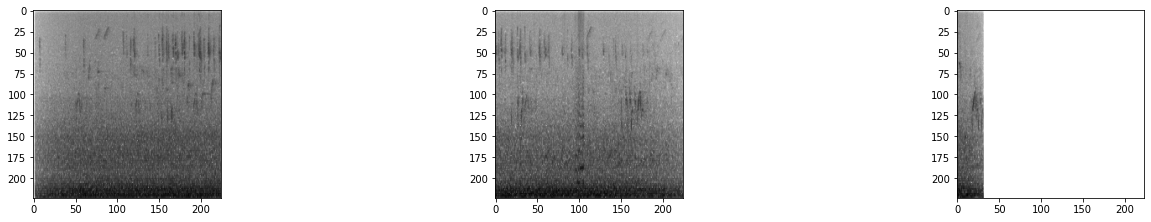

In [19]:
y, sr = librosa.load(audio_name)
sr = 22900
results = generate_split_spectrograms(y, DURATION, sr)
print(results[0].shape)
plt.figure(figsize=(40,20))
for i, element in enumerate(results):
    ax = plt.subplot(5,5, i+1)
    plt.imshow(element)
plt.show()

 

## Old Spectrogramm

(256, 216, 3)


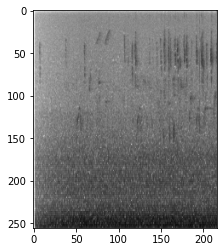

In [9]:
x = np.load("G:/Hochschule/birdclef2022/birdclef-2022/train_spectro/afrsil1/XC125458_0.npy")
print(x.shape)
plt.imshow(x)


# Preprocessing Tests

In [10]:
def median_clipping(spectrogram, number_times_larger):
    """ Compute binary image from spectrogram where cells are marked as 1 if
    number_times_larger than the row AND column median, otherwise 0
    """
    row_medians = np.median(spectrogram, axis=1)/5
    col_medians = np.median(spectrogram, axis=0)/10

    # create 2-d array where each cell contains row median
    row_medians_cond = np.tile(row_medians, (spectrogram.shape[1], 1)).transpose()
    # create 2-d array where each cell contains column median
    col_medians_cond = np.tile(col_medians, (spectrogram.shape[0], 1))

    # find cells number_times_larger than row and column median
    larger_row_median = spectrogram >= row_medians_cond*number_times_larger
    larger_col_median = spectrogram >= col_medians_cond*number_times_larger

    # create binary image with cells number_times_larger row AND col median
    binary_image = np.logical_and(larger_row_median, larger_col_median)
    return binary_image 

In [11]:
y, sr = librosa.load(audio_name)
sr = 22900
print(y.shape)
results = generate_split_spectrograms(y, DURATION, sr)
print(results[0].shape)

(244800,)
(224, 224, 3)


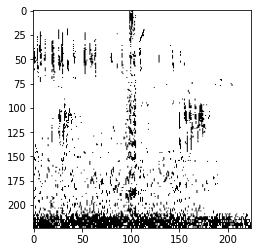

In [12]:
median_clip_image = median_clipping(results[1][:,:,0], 4)
plt.imshow(median_clip_image, cmap=plt.get_cmap("gray"))

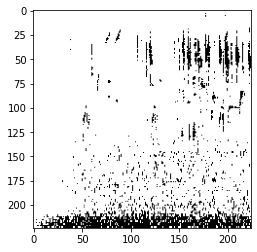

In [13]:
median_clip_image = median_clipping(results[0][:,:,0], 4)
plt.imshow(median_clip_image, cmap=plt.get_cmap("gray"))

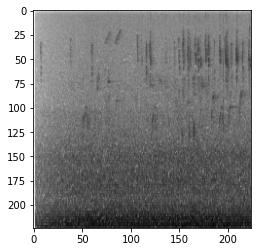

In [14]:
plt.imshow(results[0])

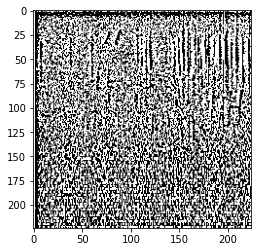

In [15]:
thresh1 = cv2.adaptiveThreshold(results[0][:,:,0],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
                                      
plt.imshow(thresh1, cmap=plt.get_cmap("gray"))   

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255   0 ...   0   0   0]
 [255 255   0 ...   0   0   0]
 [255 255   0 ...   0   0   0]]


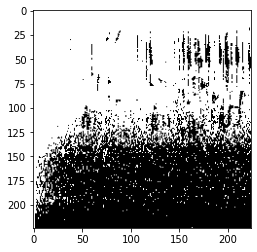

In [16]:
ret, thresh1 = cv2.threshold(results[0][:,:,0], 0, 255, cv2.THRESH_BINARY + 
                                        cv2.THRESH_OTSU)
                                      
plt.imshow(thresh1, cmap=plt.get_cmap("gray"))   

print(thresh1)

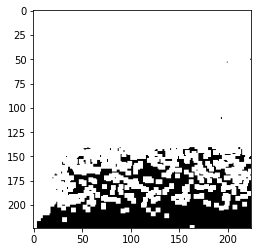

In [17]:
kernel = np.ones((5,5), np.uint8)


img_dilate = cv2.dilate(thresh1, kernel, iterations=1)
img_erode = cv2.erode(img_dilate,kernel, iterations=2)

plt.imshow(img_dilate,cmap=plt.get_cmap("gray"))


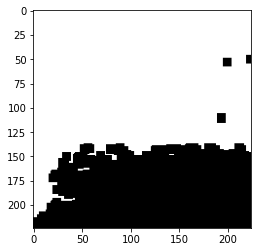

In [18]:
plt.imshow(img_erode,cmap=plt.get_cmap("gray"))